# Dose Response Example

### *Andrew Yang*

The goal of this exercise is to try to assess the different types of dose behavior we observe in L1000 data. As a case study, we'll be using signatures of ~1,500 compounds profiled at 6-point dose across multiple cell lines. It is worth noting that the previous version of the CMap L1000 resource was mostly done at 1 dose, but the recent expansion includes thousands of compounds profiled at dose.

# Setup, read in data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from __future__ import division
% matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

For simplicity, the data we'll use here is pre-subsetted to the following criteria:
* 24H
* most common dose series: 10 uM -> 40 nM in 3-fold dilutions

In [2]:
siginfo = pd.read_csv("/srv/data/workshop/data/Module4/REP.A_24H_siginfo.txt", sep="\t", na_values="-666")
siginfo.index = siginfo["sig_id"]

In [3]:
siginfo.head()

,sig_id,pert_id,pert_iname,pert_type,pert_mfc_desc,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_cc_q75,distil_ss,distil_nsample,pct_self_rank_q25,distil_ss_ngene,distil_tas,bead_batch,distil_id,brew_prefix,distil_wt,det_well,nearest_dose,median_recall_rank_spearman,median_recall_rank_wtcs.50,median_recall_score_spearman,median_recall_score_wtcs.50,batch_effect_tstat,batch_effect_tstat_pct,is_hiq
sig_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
REP.A001_A375_24H:A07,REP.A001_A375_24H:A07,BRD-K25114078,aminoguanidine,trt_cp,PIMAGEDINE HYDROCHLORIDE,A375,10.000000,uM,10 uM,24,h,24 h,0.1236,3.02548,3,11.55050,101.0,0.112980,b22,REP.A001_A375_24H_X1_B22:A07|REP.A001_A375_24H...,REP.A001_A375_24H,"0.11,0.40,0.49",A07,10.000,31.8047,40.27620,0.038539,0.167437,17.103717,71.97818,0
REP.A001_A375_24H:A08,REP.A001_A375_24H:A08,BRD-K25114078,aminoguanidine,trt_cp,PIMAGEDINE HYDROCHLORIDE,A375,3.333330,uM,3.33 uM,24,h,24 h,0.1089,2.90693,3,10.18770,97.0,0.103927,b22,REP.A001_A375_24H_X1_B22:A08|REP.A001_A375_24H...,REP.A001_A375_24H,"0.24,0.34,0.42",A08,3.330,18.9547,16.77470,0.071571,0.357316,17.103717,71.97818,0
REP.A001_A375_24H:A09,REP.A001_A375_24H:A09,BRD-K25114078,aminoguanidine,trt_cp,PIMAGEDINE HYDROCHLORIDE,A375,1.111110,uM,1.11 uM,24,h,24 h,0.1133,3.49010,3,9.94191,114.0,0.114921,b22,REP.A001_A375_24H_X1_B22:A09|REP.A001_A375_24H...,REP.A001_A375_24H,"0.24,0.40,0.36",A09,1.110,15.4117,5.51039,0.071125,0.452515,17.103717,71.97818,0
REP.A001_A375_24H:A10,REP.A001_A375_24H:A10,BRD-K25114078,aminoguanidine,trt_cp,PIMAGEDINE HYDROCHLORIDE,A375,0.370370,uM,0.37 uM,24,h,24 h,0.0563,3.00379,3,22.02860,91.0,0.072378,b22,REP.A001_A375_24H_X1_B22:A10|REP.A001_A375_24H...,REP.A001_A375_24H,"0.12,0.47,0.41",A10,0.370,44.9445,42.28800,0.011308,0.248481,17.103717,71.97818,0
REP.A001_A375_24H:A11,REP.A001_A375_24H:A11,BRD-K25114078,aminoguanidine,trt_cp,PIMAGEDINE HYDROCHLORIDE,A375,0.123457,uM,0.125 uM,24,h,24 h,0.1110,3.19218,3,9.62913,102.0,0.107595,b22,REP.A001_A375_24H_X1_B22:A11|REP.A001_A375_24H...,REP.A001_A375_24H,"0.25,0.39,0.37",A11,0.125,13.7244,31.02010,0.065648,0.183392,17.103717,71.97818,0


# Let's take a look at the data

How many total signatures are we working with?

In [4]:
len(siginfo)

109558

How many compounds?

In [5]:
cp_list = siginfo["pert_iname"].unique()
len(cp_list)

1557

Doses represented?

In [6]:
dose_series = siginfo["pert_idose"].unique()[::-1]
dose_series

array(['0.04 uM', '0.125 uM', '0.37 uM', '1.11 uM', '3.33 uM', '10 uM'], dtype=object)

Signatures per cell line?

In [7]:
siginfo["cell_id"].value_counts()

MCF7        9332
HT29        9331
YAPC        9323
PC3         9318
HA1E        9315
A375        9312
HELA        9302
A549        8297
HEK293      6953
JURKAT      6948
MCF10A      6641
MDAMB231    6285
THP1        6277
HUVEC.A     2924
Name: cell_id, dtype: int64

# Global Trends

Let's start by seeing if we see a dose response in TAS, even when aggregated across compounds and cell lines.

We would expect increasing TAS with increasing dose:

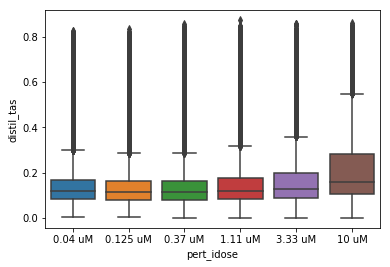

In [8]:
sns.boxplot(x="pert_idose",
            y="distil_tas",
            data=siginfo,
            order=dose_series);

What if we split by cell line?

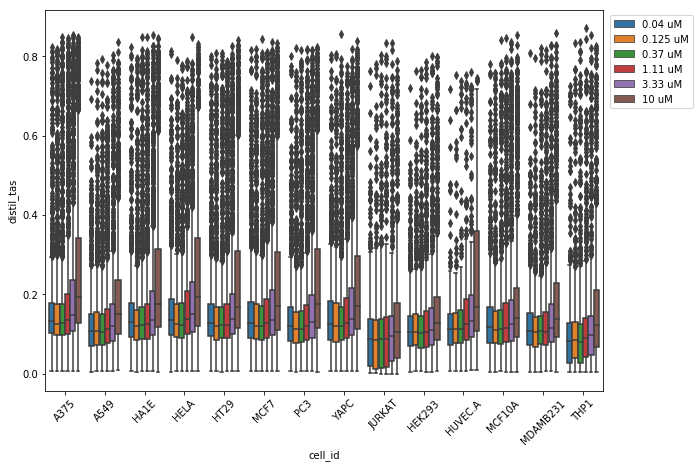

In [9]:
f, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x="cell_id",
            y="distil_tas",
            hue="pert_idose",
            data=siginfo,
            hue_order=dose_series)
plt.legend(bbox_to_anchor=(1.17,1), loc="upper right");
plt.xticks(rotation=45);

# Per compound

Now we'll take a look at dose response at the compound level. Let's keep things aggregated by cell line for now.

Let's take a look at a few compounds that might fall into some categories

### Dose-responsive: AZD-5438

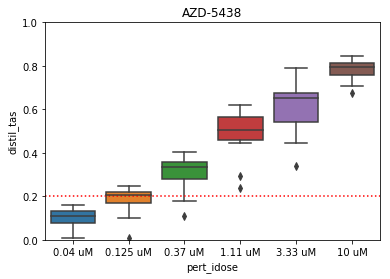

In [10]:
cp = "AZD-5438"
cp_subset = siginfo[siginfo["pert_iname"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="distil_tas",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

### Saturated: bortezomib

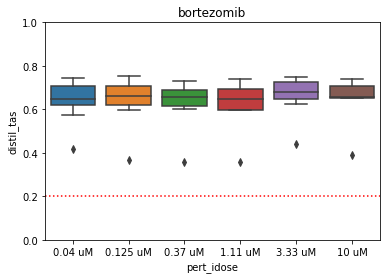

In [11]:
cp = "bortezomib"
cp_subset = siginfo[siginfo["pert_iname"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="distil_tas",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

### Inert: ibudilast

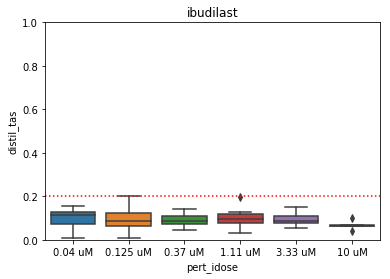

In [12]:
cp = "ibudilast"
cp_subset = siginfo[siginfo["pert_iname"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="distil_tas",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

### Other: deoxycholic-acid

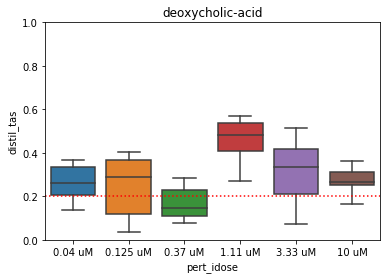

In [13]:
cp = "deoxycholic-acid"
cp_subset = siginfo[siginfo["pert_iname"] == cp]

f,ax = plt.subplots()
sns.boxplot(x="pert_idose",
            y="distil_tas",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.ylim(0,1);
ax.axhline(0.2, color="red", linestyle="dotted");

# Per compound, cell line

For some compounds, it looks like we can get at how dose-responsive they are even when aggregated across cell lines. But by aggregating, we won't see activity differences by cell line.

So let's take a deeper, unaggregated look at those compounds from above.

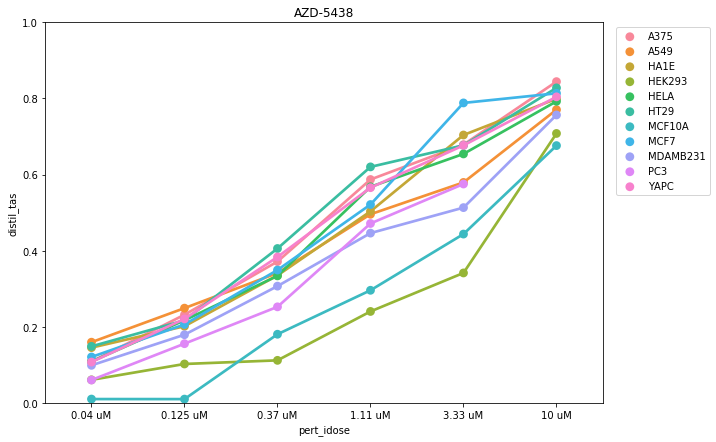

In [14]:
cp = "AZD-5438"
cp_subset = siginfo[siginfo["pert_iname"] == cp].dropna(subset=["distil_tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            hue="cell_id",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

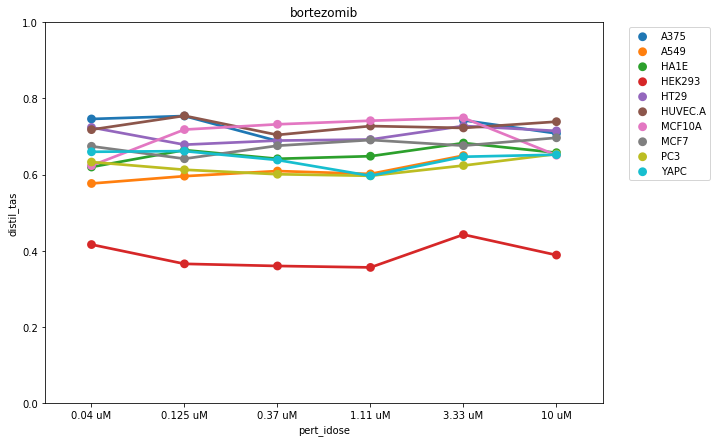

In [15]:
cp = "bortezomib"
cp_subset = siginfo[siginfo["pert_iname"] == cp].dropna(subset=["distil_tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            hue="cell_id",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

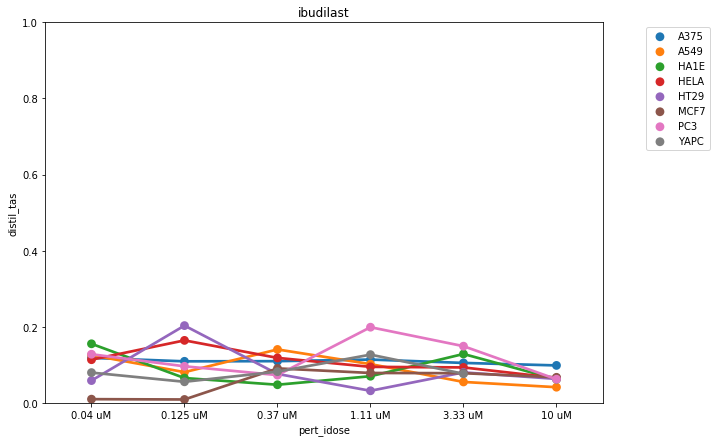

In [16]:
cp = "ibudilast"
cp_subset = siginfo[siginfo["pert_iname"] == cp].dropna(subset=["distil_tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            hue="cell_id",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

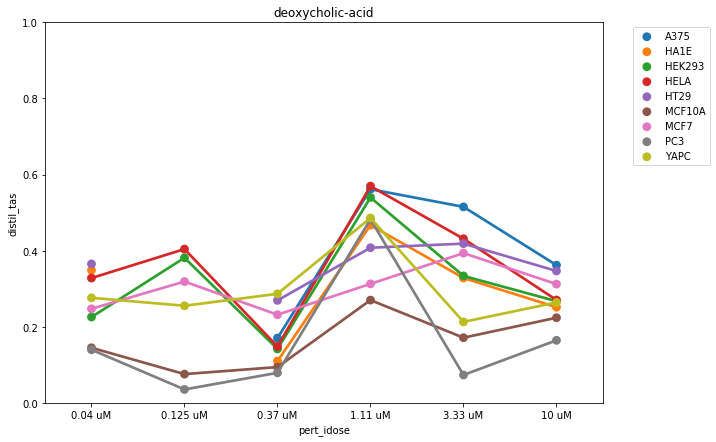

In [17]:
cp = "deoxycholic-acid"
cp_subset = siginfo[siginfo["pert_iname"] == cp].dropna(subset=["distil_tas"])

f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            hue="cell_id",
            data=cp_subset,
            order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.2,1), loc="upper right");
plt.ylim(0,1);

# Quantifying dose response

The above examples were hand-picked, but what if we wanted to systematically categorize compound-cell pairs? How about slope of TAS against dose?

Let's get unique compound-cell line pairs

In [18]:
cp_cell_pairs = list({tuple(row) for row in siginfo[["pert_iname", "cell_id"]].values})

Now let's compute a linear regression (TAS against log3 dose) for each compound-cell line pair.

The linear regression for each compound-cell pair takes about 5 minutes and the code is below. But for time's sake let's just read in the results.

In [19]:
cp_cell_metrics = pd.read_csv("/srv/data/workshop/data/Module4/REP.A_24H_cp_cell_metrics.txt", sep="\t", na_values="-666")

In [20]:
cp_cell_metrics["range_tas"] = cp_cell_metrics["max_tas"] - cp_cell_metrics["min_tas"]
cp_cell_metrics["lm_rsquared"] = cp_cell_metrics["lm_rvalue"]**2

In [21]:
cp_cell_metrics.head()

,pert_iname,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared
0,10-DEBC,A375,0.250336,0.265752,0.316825,0.352728,0.431502,False,0.068878,6,0.031353,0.334155,0.851583,0.031407,0.009650,0.181166,0.725194
1,10-DEBC,HA1E,0.080418,0.089374,0.109198,0.126371,0.346345,False,0.101317,6,0.037465,0.158476,0.691802,0.127842,0.019553,0.265927,0.478590
2,10-DEBC,HELA,0.075567,0.094545,0.104847,0.141841,0.195790,False,0.044830,6,0.004421,0.122842,0.184478,0.726423,0.011776,0.120223,0.034032
3,10-DEBC,HT29,0.090235,0.109422,0.150441,0.203087,0.291498,False,0.076508,6,0.025020,0.176610,0.611798,0.196800,0.016174,0.201263,0.374297
4,10-DEBC,MCF7,0.109670,0.139026,0.141311,0.170481,0.260272,False,0.053134,6,-0.000593,0.161599,-0.020897,0.968660,0.014197,0.150602,0.000437


How many compound-cell line pairs?

In [22]:
n_cp_cell_pairs = len(cp_cell_metrics)
n_cp_cell_pairs

16610

How many pairs are we left with if we want only those pairs where we have data in at least 5 doses? We want to make sure our slope metric is robust.

In [23]:
(cp_cell_metrics["n_doses"] >= 5).sum()

16414

That's not bad-- let's subset to just those.

In [24]:
cp_cell_metrics = cp_cell_metrics[cp_cell_metrics["n_doses"] >= 5]

## Let's take a look at the compound-cell pair with the highest slope.

In [25]:
cp_cell_metrics.sort_values(["lm_slope"], ascending=False).head(1)

,pert_iname,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared
575,MLN-2238,JURKAT,0.067137,0.148203,0.387222,0.794329,0.833469,True,0.356069,5,0.217879,0.643056,0.967501,0.006999,0.032877,0.766332,0.936058


Does it look dose-responsive?

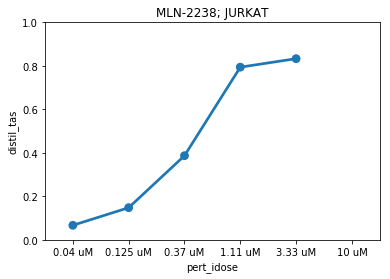

In [26]:
cp = "MLN-2238"
cell = "JURKAT"
cp_cell_subset = siginfo[(siginfo["pert_iname"] == cp) &
                         (siginfo["cell_id"] == cell)].dropna(subset=["distil_tas"])

# f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            data=cp_cell_subset,
            order=dose_series);
plt.title("{}; {}".format(cp,cell));
plt.ylim(0,1);

## What's the distribution of slopes?

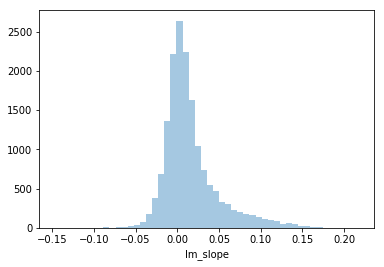

In [27]:
sns.distplot(cp_cell_metrics["lm_slope"], kde=False)

## Considering goodness of fit for dose-responsiveness

To be more conservative in our dose-responsive labeling, we might exclude situations where the slope is high, *but* $r^{2}$ < 0.7.

Let's take a look at an example:

In [28]:
cp_cell_metrics[(cp_cell_metrics["lm_slope"] > 0.15) &
                (cp_cell_metrics["lm_rsquared"] < 0.7)]

,pert_iname,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared
1443,altrenogest,YAPC,0.007499,0.042312,0.207494,0.642677,0.764882,False,0.352202,6,0.154133,0.389344,0.818726,0.046312,0.054048,0.757383,0.670311


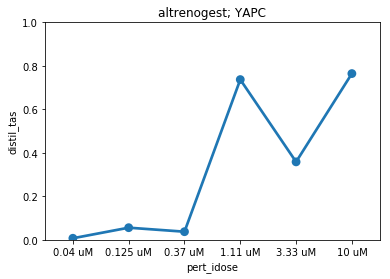

In [29]:
cp = "altrenogest"
cell = "YAPC"
cp_cell_subset = siginfo[(siginfo["pert_iname"] == cp) &
                         (siginfo["cell_id"] == cell)].dropna(subset=["distil_tas"])

# f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            data=cp_cell_subset,
            order=dose_series);
plt.title("{}; {}".format(cp,cell));
plt.ylim(0,1);

We'll want to categorize this high slope, poor fit case as "other"

Let's look at the r-squared distribution

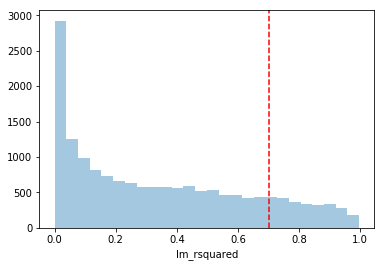

In [30]:
sns.distplot(cp_cell_metrics["lm_rsquared"], kde=False)
plt.axvline(0.7, color="red", linestyle="dashed");

This is a fairly strict fit requirement for dose-responsiveness, but for this first pass heuristic, we're just interested in being able to systematically reveal some interesting examples.

## Picking a dose-responsive slope threshold

Let's plot TAS against dose for slope bins of 0.01 from, say 0 to 0.1.

This will help us tune our heuristic for calling a compound in a cell dose-repsonsive.

In [31]:
slope_bins = [(i/100.0, (i+1)/100.0) for i in xrange(0,10)]
slope_bins

[(0.0, 0.01),
 (0.01, 0.02),
 (0.02, 0.03),
 (0.03, 0.04),
 (0.04, 0.05),
 (0.05, 0.06),
 (0.06, 0.07),
 (0.07, 0.08),
 (0.08, 0.09),
 (0.09, 0.1)]

Let's randomly sample 50 compound-cell pairs with a good linear fit ($r^{2}$ > 0.7) for each slope bin and take a look

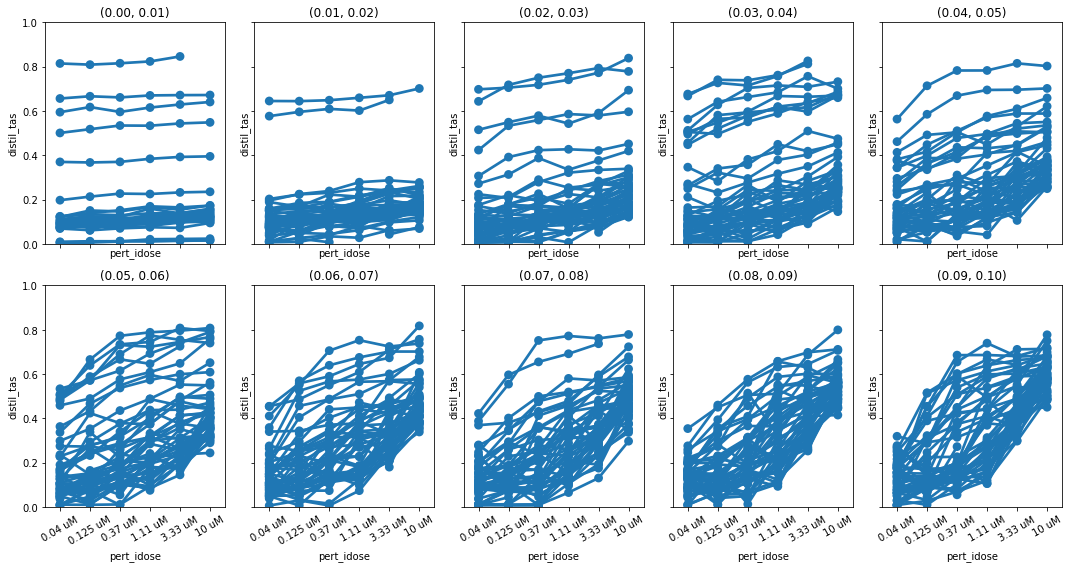

In [32]:
# set random seed so results are reproducible
np.random.seed(42)

f, ax = plt.subplots(2, 5, figsize=(15,8), sharey=True, sharex=True)
ax_list = ax.reshape(-1)
for i, slope_bin in enumerate(slope_bins):
    cp_cell_subset = cp_cell_metrics[(cp_cell_metrics["lm_slope"].between(*slope_bin)) &
                                     (cp_cell_metrics["lm_rsquared"] > 0.7)]
    # let's sample 50 cp-cell pairs, unless there are fewer
    if len(cp_cell_subset) >= 50:
        sample = cp_cell_subset.sample(50)
    else:
        sample = cp_cell_subset
    cp_cell_pairs = zip(sample["pert_iname"].values, sample["cell_id"].values)
    siginfo_sample = pd.DataFrame()

    for pair in cp_cell_pairs:
        cp, cell = pair
        # subset signatures with current compound-cell combination
        siginfo_subset = siginfo[(siginfo["pert_iname"] == cp) &
                                 (siginfo["cell_id"] == cell)]
        cur_ax = ax_list[i]
        sns.pointplot(x="pert_idose",
                      y="distil_tas",
                      data=siginfo_subset,
                      order=dose_series,
                      ax=cur_ax);
        cur_ax.set_title("({:.2f}, {:.2f})".format(*slope_bin));
        cur_ax.set_ylim(0,1);
        cur_ax.set_xticklabels(dose_series, rotation=30);
    plt.tight_layout();

Let's define dose-responsive compound-cell pairs as those with a slope > 0.02

## Considering TAS range for low slope (defining inert/saturated)

For those with low slopes, let's wave the good fit requirement, and require a TAS range < 0.2.

In [33]:
cp_cell_metrics[(cp_cell_metrics["lm_slope"] < 0.02) &
                (cp_cell_metrics["range_tas"] > 0.2)].head()

,pert_iname,cell_id,min_tas,q25_tas,median_tas,q75_tas,max_tas,is_monotonic,sd_tas,n_doses,lm_slope,lm_intercept,lm_rvalue,lm_pvalue,lm_stderr,range_tas,lm_rsquared
22,17-hydroxyprogesterone-caproate,YAPC,0.007634,0.131108,0.175212,0.212336,0.220211,False,0.080959,6,0.010516,0.157481,0.243017,0.642650,0.020989,0.212577,0.059057
28,"2',5'-dideoxyadenosine",PC3,0.008338,0.048564,0.068305,0.137848,0.268907,False,0.095546,6,-0.006082,0.100354,-0.119087,0.822214,0.025354,0.260569,0.014182
31,2-iminobiotin,A549,0.078974,0.109035,0.136247,0.190557,0.280131,False,0.074172,6,0.008323,0.160067,0.209931,0.689730,0.019381,0.201158,0.044071
33,2-iminobiotin,HELA,0.045361,0.050734,0.066839,0.087336,0.314270,False,0.103778,6,-0.008383,0.102087,-0.151117,0.775049,0.027417,0.268908,0.022836
60,3-amino-benzamide,HT29,0.030133,0.065215,0.071495,0.100845,0.298034,False,0.096759,6,-0.026239,0.096881,-0.507326,0.304299,0.022285,0.267901,0.257379


Let's take a look at one of these low-slope, high TAS range cases:

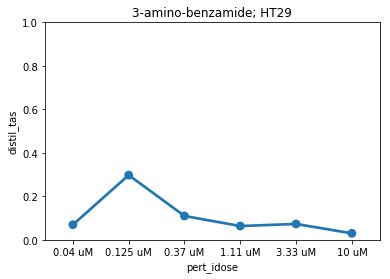

In [34]:
cp = "3-amino-benzamide"
cell = "HT29"
cp_cell_subset = siginfo[(siginfo["pert_iname"] == cp) &
                         (siginfo["cell_id"] == cell)].dropna(subset=["distil_tas"])

# f, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x="pert_idose",
            y="distil_tas",
            data=cp_cell_subset,
            order=dose_series);
plt.title("{}; {}".format(cp,cell));
plt.ylim(0,1);

We'll want to categorize this low-slope, high TAS range case as "other"

### For our dose-response categories, we'll exclude cases where the fit is poor *except* where we suspect the dose curve is flat (low slope with low TAS range)

## Define heuristics for categorizing

Let's define the following categories:

**dose-responsive (strong)**:
* high slope with good fit
* median TAS >= 0.2

**dose-responsive (subtle)**:
* high slope with good fit
* median TAS < 0.2

**saturated**:
* low slope with low TAS range
* median TAS >= 0.2

**inert**:
* low slope with low TAS range
* median TAS < 0.2

**other**:
* everything else

Now let's categorize according to these heuristics

In [35]:
cp_cell_metrics["category"] = "other"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] > 0.02) &
                     (cp_cell_metrics["lm_rsquared"] > 0.7) &
                     (cp_cell_metrics["median_tas"] >= 0.2)), "category"] = "dose-responsive-strong"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] > 0.02) &
                     (cp_cell_metrics["lm_rsquared"] > 0.7) &
                     (cp_cell_metrics["median_tas"] < 0.2)), "category"] = "dose-responsive-subtle"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] <= 0.02) &
                     (cp_cell_metrics["range_tas"] < 0.2) &
                     (cp_cell_metrics["median_tas"] >= 0.2)), "category"] = "saturated"

cp_cell_metrics.loc[((cp_cell_metrics["lm_slope"] <= 0.02) &
                     (cp_cell_metrics["range_tas"] < 0.2) &
                     (cp_cell_metrics["median_tas"] < 0.2)), "category"] = "inert"

And let's take a look at the dose-response categories ("other" excluded)

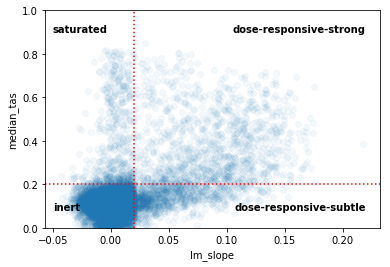

In [36]:
# f, ax = plt.subplots()
sns.scatterplot(x="lm_slope",
                y="median_tas",
                data=cp_cell_metrics[cp_cell_metrics["category"] != "other"],
                alpha=0.05, edgecolor=None);
plt.axhline(0.2, color="red", linestyle="dotted");
plt.axvline(0.02, color="red", linestyle="dotted");
plt.ylim(0,1.0);

plt.text(0.22, 0.9, "dose-responsive-strong", horizontalalignment="right", weight="semibold");
plt.text(0.22, 0.08, "dose-responsive-subtle", horizontalalignment="right", weight="semibold");
plt.text(-0.05, 0.08, "inert", horizontalalignment="left", weight="semibold");
plt.text(-0.05, 0.9, "saturated", horizontalalignment="left", weight="semibold");

In [37]:
cats = ["dose-responsive-strong", "dose-responsive-subtle", "saturated", "inert", "other"]
arr = [(cp_cell_metrics["category"] == x).sum() / n_cp_cell_pairs * 100 for x in cats]

6.76% dose-responsive-strong
5.41% dose-responsive=subtle
3.43% saturated
56.66% inert
26.56% other


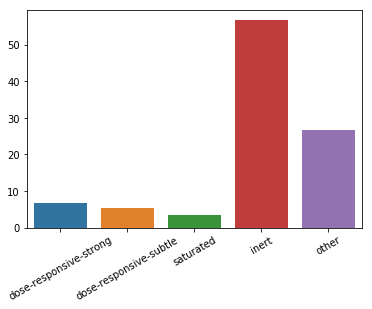

In [38]:
sns.barplot(x=cats, y=pd.Series(arr))
plt.xticks(rotation=30)

print "{:.2f}% dose-responsive-strong".format((cp_cell_metrics["category"] == "dose-responsive-strong").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% dose-responsive=subtle".format((cp_cell_metrics["category"] == "dose-responsive-subtle").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% saturated".format((cp_cell_metrics["category"] == "saturated").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% inert".format((cp_cell_metrics["category"] == "inert").sum() / n_cp_cell_pairs * 100)
print "{:.2f}% other".format((cp_cell_metrics["category"] == "other").sum() / n_cp_cell_pairs * 100)

# Finding cell-specific dose-response

Let's take a look at how many cases in each category appear per compound

In [39]:
# get categories represented per compound
agg_categorized = cp_cell_metrics.groupby(["pert_iname"])["category"].apply(list).reset_index()
agg_categorized["n_cells_dose-responsive-strong"] = agg_categorized["category"].apply(lambda x: x.count("dose-responsive-strong"))
agg_categorized["n_cells_dose-responsive-subtle"] = agg_categorized["category"].apply(lambda x: x.count("dose-responsive-subtle"))
agg_categorized["n_cells_saturated"] = agg_categorized["category"].apply(lambda x: x.count("saturated"))
agg_categorized["n_cells_inert"] = agg_categorized["category"].apply(lambda x: x.count("inert"))
agg_categorized["n_cells_other"] = agg_categorized["category"].apply(lambda x: x.count("other"))
agg_categorized["n_cells"] = agg_categorized["category"].apply(lambda x: len(x))
agg_categorized = agg_categorized.drop(["category"], axis=1)
agg_categorized.head()

,pert_iname,n_cells_dose-responsive-strong,n_cells_dose-responsive-subtle,n_cells_saturated,n_cells_inert,n_cells_other,n_cells
0,10-DEBC,1,0,0,3,2,6
1,17-hydroxyprogesterone-caproate,0,0,0,2,6,8
2,"2',5'-dideoxyadenosine",0,0,0,5,2,7
3,2-iminobiotin,0,0,0,5,3,8
4,2-methoxyestradiol,3,1,0,1,1,6


We can now look for various combinations of our categories to find interesting differential cell line activity

Let's start with a case where the compound was:
* inert in a majority of cell lines
* saturated or dose-responsive-strong in at least 1 cell line

In [40]:
agg_categorized[(agg_categorized["n_cells_inert"] / agg_categorized["n_cells"] > 1/2) &
                ((agg_categorized["n_cells_saturated"] >= 1) |
                (agg_categorized["n_cells_dose-responsive-strong"] >= 1))]

,pert_iname,n_cells_dose-responsive-strong,n_cells_dose-responsive-subtle,n_cells_saturated,n_cells_inert,n_cells_other,n_cells
36,FK-866,0,0,3,4,0,7
61,PF-04217903,0,0,1,10,0,11
71,SR-27897,0,0,1,6,2,9
77,TTNPB,1,1,4,7,0,13
97,acetazolamide,0,0,1,9,2,12
120,alaproclate,0,1,1,10,1,13
125,alizapride,0,0,1,10,2,13
128,almorexant,1,0,0,11,1,13
138,ambrisentan,0,0,1,7,4,12
140,amcinonide,0,0,2,4,1,7


## A few examples of differential cell line dose-responsiveness

,pert_iname,cell_id,lm_slope,lm_rsquared,range_tas,category,n_doses
7067,fulvestrant,A375,0.013347,0.693373,0.087272,inert,6
7068,fulvestrant,A549,0.031201,0.541262,0.222473,other,6
7069,fulvestrant,HA1E,0.012921,0.160371,0.154814,inert,6
7070,fulvestrant,HEK293,-0.001614,0.006649,0.098431,inert,6
7071,fulvestrant,HELA,0.011172,0.071254,0.237376,other,6
7072,fulvestrant,HT29,-0.000481,0.000381,0.114084,inert,6
7073,fulvestrant,JURKAT,-0.014271,0.150644,0.197752,inert,6
7074,fulvestrant,MCF10A,-0.002735,0.011408,0.139381,inert,6
7075,fulvestrant,MCF7,0.000843,0.012142,0.043074,saturated,6
7076,fulvestrant,MDAMB231,0.045829,0.720292,0.186149,dose-responsive-subtle,5


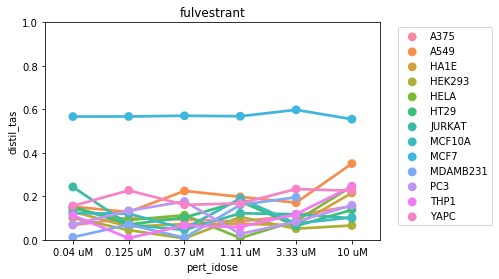

In [41]:
cp = "fulvestrant"
cp_subset = siginfo[siginfo["pert_iname"] == cp].dropna(subset=["distil_tas"])

f, ax = plt.subplots()
sns.pointplot(x="pert_idose", y="distil_tas", hue="cell_id", data=cp_subset, order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.35,1), loc="upper right");
plt.ylim(0,1);

cp_cell_metrics[cp_cell_metrics["pert_iname"] == cp][["pert_iname", "cell_id", "lm_slope", "lm_rsquared", "range_tas", "category", "n_doses"]]


Fulvestrant is an estrogen receptor antagonist, and the two breast cancer lines were the only ones not to be categorized as inert or other. MCF7 was called saturated, and MDAMB231 was called dose-responsive. Interestingly, MCF10A, a non-cancerous breast line was called inert.

,pert_iname,cell_id,lm_slope,lm_rsquared,range_tas,category,n_doses
11004,norethisterone,A375,0.030115,0.467199,0.236219,other,6
11005,norethisterone,HA1E,0.000989,0.005522,0.073451,inert,6
11006,norethisterone,HEK293,0.011236,0.404959,0.089351,inert,6
11007,norethisterone,HELA,0.138316,0.939148,0.604568,dose-responsive-strong,6
11008,norethisterone,HT29,0.013375,0.243981,0.123367,inert,6
11009,norethisterone,MCF10A,0.020105,0.388244,0.146001,other,6
11010,norethisterone,MCF7,0.014463,0.353271,0.138707,inert,6
11011,norethisterone,PC3,-0.004079,0.045141,0.089463,inert,6
11012,norethisterone,YAPC,0.004835,0.099331,0.074574,inert,6


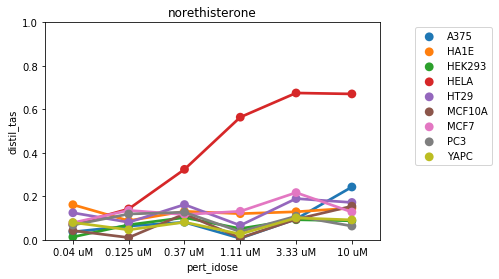

In [42]:
cp = "norethisterone"
cp_subset = siginfo[siginfo["pert_iname"] == cp].dropna(subset=["distil_tas"])

f, ax = plt.subplots()
sns.pointplot(x="pert_idose", y="distil_tas", hue="cell_id", data=cp_subset, order=dose_series);
plt.title(cp);
plt.legend(bbox_to_anchor=(1.35,1), loc="upper right");
plt.ylim(0,1);

cp_cell_metrics[cp_cell_metrics["pert_iname"] == cp][["pert_iname", "cell_id", "lm_slope", "lm_rsquared", "range_tas", "category", "n_doses"]]
